In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv3D, Conv2D, MaxPool3D, MaxPool2D, Input, AvgPool3D, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply
from keras.layers import Activation, GlobalMaxPool3D, GlobalMaxPool2D, SpatialDropout3D, SpatialDropout2D, GlobalAvgPool3D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate, LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

MessageError: ignored

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
eeg_signal = []
valence = []
arousal = []
dominance = []
signal_freq = []
window_size = 32
skip = 32
gc.collect()

for person in range(1,33):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<4] = 0
  label[(label>=4) & (label<6)] = 1
  label[label>=6] = 2

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label
  #dom = label.T[2] # Dominance label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    valence.append(val[i])
    arousal.append(aro[i])
    sig = eeg[i]
    sig = sig[:32, 384:]
    eeg_signal.append(sig)
  del eeg, val, aro
eeg_signal = np.reshape(eeg_signal,[-1,32,7680,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal, sig
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)
#dominance = np.asarray(dominance, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape, valence[valence == 2].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape, arousal[arousal == 2].shape)
#print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
#dominance = np_utils.to_categorical(dominance)

Person No.1
Person No.2
Person No.3
Person No.4
Person No.5
Person No.6
Person No.7
Person No.8
Person No.9
Person No.10
Person No.11
Person No.12
Person No.13
Person No.14
Person No.15
Person No.16
Person No.17
Person No.18
Person No.19
Person No.20
Person No.21
Person No.22
Person No.23
Person No.24
Person No.25
Person No.26
Person No.27
Person No.28
Person No.29
Person No.30
Person No.31
Person No.32
(1280, 32, 7680, 1)
(1280,) (356,) (378,) (546,)
(1280,) (368,) (380,) (532,)


In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data,valence, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1024, 32, 7680, 1) (256, 32, 7680, 1) (1024, 3) (256, 3)


# **Proposed Architecture**

In [ ]:
def CNN1D(x): #power of each window
  x = BatchNormalization(name='BatchNormalization_1')(x)
  x1 = Conv1D(filters = 10, kernel_size = 32, strides = 1, padding = 'same', name = 'Conv1D_1')(x)
  x1 = LeakyReLU(alpha=0.3, name='LeakyReLU-activation_1')(x1)
  x1 = AvgPool1D(pool_size=256, name='AvgPool1D_1')(x1)
  x2 = Conv1D(filters = 10, kernel_size = 16, strides = 1, padding = 'same', name = 'Conv1D_2')(x)
  x2 = LeakyReLU(alpha=0.3, name='LeakyReLU-activation_2')(x2)
  x2 = AvgPool1D(pool_size=256, name='AvgPool1D_2')(x2)
  x3 = Conv1D(filters = 10, kernel_size = 8, strides = 1, padding = 'same', name = 'Conv1D_3')(x)
  x3 = LeakyReLU(alpha=0.3, name='LeakyReLU-activation_3')(x3)
  x3 = AvgPool1D(pool_size=256, name='AvgPool1D_3')(x3)
  x4 = Conv1D(filters = 10, kernel_size = 4, strides = 1, padding = 'same', name = 'Conv1D_4')(x)
  x4 = LeakyReLU(alpha=0.3, name='LeakyReLU-activation_4')(x4)
  x4 = AvgPool1D(pool_size=256, name='AvgPool1D_4')(x4)
  x = Concatenate(axis = 1, name = 'Concatenate_1')([x1, x2, x3, x4])
  x = BatchNormalization(name = 'BatchNormalization_2')(x)
  x = Flatten(name = 'Flatten_1')(x)
  x = Dense(512, activation='tanh', name='Dense_1') (x)
  x = Dropout(0.4, name='Dropout_1')(x)
  x = Dense(32, activation='relu', name='Dense_2') (x)
  x = Dropout(0.4, name='Dropout_2')(x)
  x = Dense(3, activation='softmax', name='Dense_3') (x)
  return x

In [ ]:
def CNN1D_get_model() :
  input_shape = (data.shape[2],1)
  a = Input(input_shape, name='Input')
  out = CNN1D(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=[tf.keras.metrics.CategoricalAccuracy(),
                                                                     tf.keras.metrics.CategoricalCrossentropy(), 
                                                                     tf.keras.metrics.AUC(),
                                                                     tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()], optimizer=opt)
  return model
model = CNN1D_get_model()
print(model.summary())

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 7680, 1)]    0           []                               
                                                                                                  
 BatchNormalization_1 (BatchNor  (None, 7680, 1)     4           ['Input[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Conv1D_1 (Conv1D)              (None, 7680, 10)     330         ['BatchNormalization_1[0][0]']   
                                                                                                  
 Conv1D_2 (Conv1D)              (None, 7680, 10)     170         ['BatchNormalization_1[0][

In [ ]:
batch_size = 64
epochs = 30
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

2463

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

In [ ]:
xf_test = []
Xf_train = []
for i in range(32):
  print("Channel No.",i+1)
  foldNum=0
  model = CNN1D_get_model()
  for train_index, val_index in kfold.split(X_train[:,i,:,:], Y_train):
    foldNum = foldNum + 1
    print("Results for fold",foldNum)
    x_train, x_val = X_train[:,i,:,:][train_index], X_train[:,i,:,:][val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]
    d_class_weights = call_class_weights(y_train)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights, verbose=0, validation_data=(x_val, y_val),shuffle=True)
    model.evaluate(x_test[:,i,:,:], y_test)
    gc.collect() # Garbage collecter
    del x_train, x_val, y_train, y_val
  layer_name = 'Dense_1'
  intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  xf_test.append(intermediate_layer_model.predict(x_test[:,i,:,:]))
  Xf_train.append(intermediate_layer_model.predict(X_train[:,i,:,:]))

Channel No. 1
Results for fold 1
8/8 [==============================] - 1s 21ms/step - loss: 1.0931 - categorical_accuracy: 0.3398 - categorical_crossentropy: 1.0931 - auc_8: 0.5474 - precision_8: 0.4000 - recall_8: 0.0078
Results for fold 2
8/8 [==============================] - 0s 16ms/step - loss: 1.1430 - categorical_accuracy: 0.3320 - categorical_crossentropy: 1.1430 - auc_8: 0.5020 - precision_8: 0.3333 - recall_8: 0.0430
Results for fold 3
8/8 [==============================] - 0s 17ms/step - loss: 1.2552 - categorical_accuracy: 0.3203 - categorical_crossentropy: 1.2552 - auc_8: 0.4883 - precision_8: 0.2800 - recall_8: 0.0820
Results for fold 4
8/8 [==============================] - 0s 21ms/step - loss: 1.3027 - categorical_accuracy: 0.3047 - categorical_crossentropy: 1.3027 - auc_8: 0.4946 - precision_8: 0.2778 - recall_8: 0.0977
Results for fold 5
8/8 [==============================] - 0s 18ms/step - loss: 1.3809 - categorical_accuracy: 0.3125 - categorical_crossentropy: 1.380

In [ ]:
xf_test = np.asarray(xf_test, dtype = np.float32)
Xf_train = np.asarray(Xf_train, dtype = np.float32)
df = []
for i in range(X_train.shape[0]):
  df.append(Xf_train[:,i,:])
X_train = np.reshape(df,[-1,32,512,1])
df = []
for i in range(x_test.shape[0]):
  df.append(xf_test[:,i,:])
x_test = np.reshape(df,[-1,32,512,1])
del df, Xf_train, xf_test
print(X_train.shape, x_test.shape)

(1024, 32, 512, 1) (256, 32, 512, 1)


In [ ]:
def get_channel_attention(x):
  y = AvgPool2D(pool_size=(1,512), name='AvgPool2D_1')(x)
  y = Flatten(name='Flatten_1')(y)
  y = Dense(8,activation='tanh', name='Dense_1') (y)
  y = BatchNormalization(name='BatchNormalization_1')(y)
  y = Dropout(0.3, name='Dropout_1')(y)
  y = Dense(32,activation='sigmoid', name='Dense_2') (y)
  z = []
  for i in range(x.shape[2]):
    z.append(y)
  y = Concatenate(name='Concatenate_1')(z)
  y = Reshape((32, 512, 1), name='Reshape_1')(y)
  x = Multiply(name='Multiply_1')([x,y])
  #x = Reshape((32, 512, 1), name='Reshape_2')(x)
  return x

In [ ]:
def get_model() :
  input_shape = (X_train.shape[1],X_train.shape[2],1)
  a = Input(input_shape, name='Input')
  x = get_channel_attention(a)
  x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', name='Conv2D_1')(x)
  x = BatchNormalization(name='BatchNormalization_2')(x)
  x = Dropout(0.2, name='Dropout_2')(x)
  x = MaxPooling2D(pool_size=(2,4), name='MaxPooling2D_1')(x)
  x = Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same', name='Conv2D_2')(x)
  x = BatchNormalization(name='BatchNormalization_3')(x)
  x = Dropout(0.2, name='Dropout_3')(x)
  x = MaxPooling2D(pool_size=(2,4), name='MaxPooling2D_2')(x)
  x = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding='same', name='Conv2D_3')(x)
  x = BatchNormalization(name='BatchNormalization_4')(x)
  x = Dropout(0.2, name='Dropout_4')(x)
  x = MaxPooling2D(pool_size=(2,4), name='MaxPooling2D_3')(x)
  x = Flatten(name='Flatten_2')(x)
  x = Dense(512,activation='tanh', name='Dense_3')(x)
  x = Dropout(0.4, name='Dropout_5')(x)
  x = Dense(32,activation='relu', name='Dense_4')(x)
  x = Dropout(0.4, name='Dropout_6')(x)
  x = Dense(3,activation='softmax', name='Dense_5')(x)
  model = Model(a, x)
  opt = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
print(model.summary())

Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 512, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 AvgPool2D_1 (AveragePooling2D)  (None, 32, 1, 1)    0           ['Input[0][0]']                  
                                                                                                  
 Flatten_1 (Flatten)            (None, 32)           0           ['AvgPool2D_1[0][0]']            
                                                                                                  
 Dense_1 (Dense)                (None, 8)            264         ['Flatten_1[0][0]']       

In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
15/15 [==============================] - 4s 103ms/step - loss: 1.3236 - accuracy: 0.3355 - val_loss: 1.1002 - val_accuracy: 0.4369
Epoch 2/30
15/15 [==============================] - 1s 53ms/step - loss: 1.0879 - accuracy: 0.4343 - val_loss: 1.0914 - val_accuracy: 0.4369
Epoch 3/30
15/15 [==============================] - 1s 53ms/step - loss: 1.0794 - accuracy: 0.4343 - val_loss: 1.0855 - val_accuracy: 0.4369
Epoch 4/30
15/15 [==============================] - 1s 53ms/step - loss: 1.0769 - accuracy: 0.4343 - val_loss: 1.0838 - val_accuracy: 0.4369
Epoch 5/30
15/15 [==============================] - 1s 53ms/step - loss: 1.0767 - accuracy: 0.4343 - val_loss: 1.0830 - val_accuracy: 0.4369
Epoch 6/30
15/15 [==============================] - 1s 54ms/step - loss: 1.0766 - accuracy: 0.4343 - val_loss: 1.0800 - val_accuracy: 0.4369
Epoch 7/30
15/15 [==============================] - 1s 54ms/step - loss: 1.0766 - accuracy: 0.4343 - val_loss: 1.0812 - val_accuracy: 

8/8 [==============================] - 0s 13ms/step - loss: 1.0935 - accuracy: 0.3945
Accuracy  : 0.39453125
F1_Score  : 0.18860877684407096


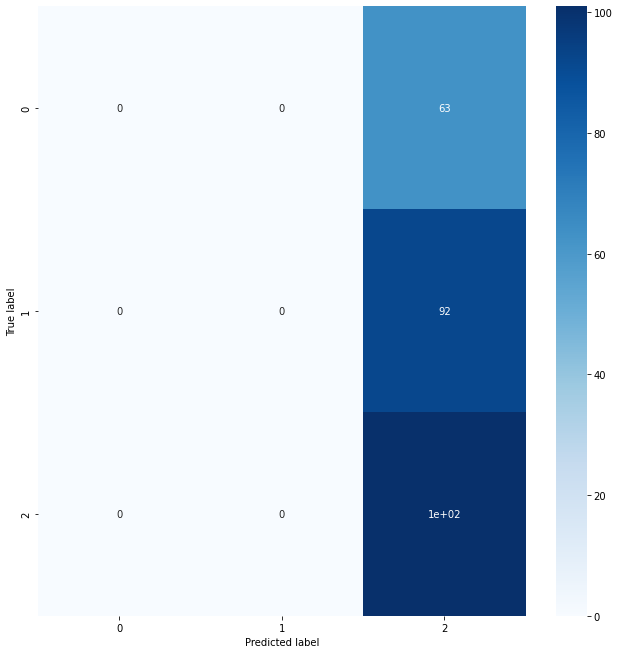

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
#c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Old**

In [ ]:
def get_channel_attention(x):
  y = Conv2D(filters=4, kernel_size=(3,1), strides=(1,1), padding='same')(x)
  y = BatchNormalization()(y)
  y = Dropout(0.2)(y)
  y = MaxPooling2D(pool_size=(2,1))(y)
  y = Conv2D(filters=8, kernel_size=(5,1), strides=(1,1), padding='same')(y)
  y = BatchNormalization()(y)
  y = Dropout(0.2)(y)
  y = MaxPooling2D(pool_size=(3,1))(y)
  y = Conv2D(filters=16, kernel_size=(7,1), strides=(1,1), padding='same')(y)
  y = BatchNormalization()(y)
  y = Dropout(0.2)(y)
  y = MaxPooling2D(pool_size=(5,1))(y)
  y = Conv2D(filters=32, kernel_size=(3,1), strides=(1,1), padding='same')(y)
  y = BatchNormalization()(y)
  y = Dropout(0.2)(y)
  y = MaxPooling2D(pool_size=(8,1))(y)
  y = Reshape((32, 32, 1))(y)
  y = AvgPool2D(pool_size=(1,32))(y)
  y = Dropout(0.2)(y)
  '''
  y = AvgPool2D(pool_size=(1,32), name='AvgPool2D_1')(x)'''
  y = Flatten(name='Flatten_1')(y)
  y = Dense(x.shape[2]/8,activation='tanh', name='Dense_1') (y)
  y = BatchNormalization(name='BatchNormalization_5')(y)
  y = Dropout(0.4, name='Dropout_5')(y)
  y = Dense(y.shape[1]*8,activation='tanh', name='Dense_2') (y)
  #y = BatchNormalization(name='BatchNormalization_6')(y)
  #y = Dropout(0.4, name='Dropout_6')(y)
  #y = Dense(y.shape[1]/2,activation='sigmoid', name='Dense_3') (y)
  #y = Dropout(0.4, name='Dropout_7')(y)
  z = []
  for i in range(x.shape[1]):
    z.append(y)
  y = Concatenate(name='Concatenate_1')(z)
  y = Reshape((240, 32, 1), name='Reshape_3')(y)
  x = Multiply(name='Multiply_2')([x,y])
  x = Reshape((240, 32,1), name='Reshape_4')(x)
  return x

In [ ]:
def get_model() :
  input_shape = (data.shape[1],data.shape[2],data.shape[3],1)
  a = Input(input_shape)
  out = get_data_samples_info(a)
  out = get_channel_attention(out)
  #model=Sequential()
  out = Conv2D(filters=8, kernel_size=(5,5), strides=(2,1), padding='same', name='Conv2D_1')(out)
  out = BatchNormalization(name='BatchNormalization_7')(out)
  out = MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_1')(out)
  out = Dropout(0.2, name='Dropout_8')(out)
  out = Conv2D(filters=16, kernel_size=(7,7), strides=(3,1), padding='same', name='Conv2D_2')(out)
  out = BatchNormalization(name='BatchNormalization_8')(out)
  out = MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_2')(out)
  out = Dropout(0.2, name='Dropout_9')(out)
  out = Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same', name='Conv2D_3')(out)
  out = BatchNormalization(name='BatchNormalization_9')(out)
  out = MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_3')(out)
  out = Dropout(0.2, name='Dropout_10')(out)
  out = Flatten(name='Flatten_2')(out)
  out = Dense(256,activation='tanh')(out)
  out = Dropout(0.4, name='Dropout_11')(out)
  out = Dense(32,activation='relu')(out)
  out = Dropout(0.4, name='Dropout_12')(out)
  out = Dense(3,activation='softmax')(out)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 32, 32  0           []                               
                                , 1)]                                                             
                                                                                                  
 Conv3D_1 (Conv3D)              (None, 240, 32, 32,  20          ['input_3[0][0]']                
                                 4)                                                               
                                                                                                  
 BatchNormalization_1 (BatchNor  (None, 240, 32, 32,  16         ['Conv3D_1[0][0]']               
 malization)                     4)                                                         

In [ ]:
'''
def get_model() :
  input_shape = (data.shape[1],data.shape[2],data.shape[3],1)
  a = Input(input_shape)
  out = get_data_samples_info(a)
  out = get_channel_attention(out)
  #out = get_window_sequence_info(b)
  #model = Model(a, out)
  model=Sequential()
  model.add(Model(a, out))
  model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,1), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=64, kernel_size=(7,7), strides=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM((60), activation='tanh', batch_input_shape=(None,240,32),return_sequences=True)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Bidirectional(LSTM((60), activation='relu', return_sequences=True)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Bidirectional(LSTM((60), activation='elu', return_sequences=False)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(256,activation='tanh'))
  model.add(Dropout(0.4))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(3,activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
print(model.summary())
'''

In [ ]:
'''
def get_model() :
    input_shape = (data.shape[1],data.shape[2],data.shape[3],1)
    model=Sequential()
    model.add(Conv3D(filters=16, kernel_size=(3,3,8), strides=(1,1,2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.2))
    model.add(Conv3D(filters=32, kernel_size=(5,5,5), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.2))
    model.add(Conv3D(filters=64, kernel_size=(7,7,7), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.2))
    model.add(Conv3D(filters=32, kernel_size=(5,5,5), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3,activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
    return model
model = get_model()
model.summary()
'''

# **Valence**

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  #model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  layer_name = 'Dense_2'
  intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  intermediate_output = intermediate_layer_model.predict(x_test)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/30
29/29 [==============================] - 75s 2s/step - loss: 1.1788 - accuracy: 0.3692 - val_loss: 1.0996 - val_accuracy: 0.4175
Epoch 2/30
29/29 [==============================] - 71s 2s/step - loss: 1.1229 - accuracy: 0.4039 - val_loss: 1.0901 - val_accuracy: 0.4369
Epoch 3/30
29/29 [==============================] - 71s 2s/step - loss: 1.1008 - accuracy: 0.4278 - val_loss: 1.0986 - val_accuracy: 0.4175
Epoch 4/30
29/29 [==============================] - 71s 2s/step - loss: 1.0924 - accuracy: 0.4354 - val_loss: 1.0853 - val_accuracy: 0.4466
Epoch 5/30
29/29 [==============================] - 71s 2s/step - loss: 1.0869 - accuracy: 0.4245 - val_loss: 1.0818 - val_accuracy: 0.4369
Epoch 6/30
29/29 [==============================] - 71s 2s/step - loss: 1.0885 - accuracy: 0.4213 - val_loss: 1.0889 - val_accuracy: 0.4369
Epoch 7/30
29/29 [==============================] - 71s 2s/step - loss: 1.0872 - accuracy: 0.4311 - val_loss: 1.0797 - val_accuracy: 0.4369
E

KeyboardInterrupt: ignored

In [ ]:
print(intermediate_output.shape)
print(intermediate_output[0,:])

(256, 32)
[ 0.3131164  -0.1580573   0.13697991  0.23789255 -0.4543351  -0.25573733
 -0.3586486  -0.30065918 -0.35399267  0.35143137 -0.07798071  0.05603994
 -0.08898091  0.02278246 -0.37165695 -0.02747468 -0.31473905  0.05988819
  0.01004803 -0.3488593   0.28138164 -0.06593439 -0.25799796 -0.10766736
  0.03267057  0.1256802  -0.0949292  -0.30965248  0.26557216  0.0714929
 -0.17453739  0.02032313]


In [ ]:
print(intermediate_output[4,:])

[ 3.25519711e-01 -1.83422014e-01  1.54731944e-01  2.55841523e-01
 -4.33328360e-01 -2.29832947e-01 -3.49894851e-01 -3.06481361e-01
 -3.43279123e-01  3.56946141e-01 -8.06292295e-02  7.35025555e-02
 -1.16506696e-01  2.07025558e-04 -3.72087628e-01 -3.30786780e-02
 -3.19745630e-01  6.25137687e-02 -3.60354632e-02 -3.68111461e-01
  2.87451148e-01 -6.68187961e-02 -2.61604995e-01 -1.22668579e-01
  3.61218490e-02  1.07563213e-01 -7.29484037e-02 -3.17554474e-01
  2.61478215e-01  7.22712576e-02 -1.66113958e-01 -2.88187172e-02]


In [ ]:
y_test[4]

array([1., 0., 0.], dtype=float32)

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(7456, 200, 256, 1) (1864, 200, 256, 1) (7456, 2) (1864, 2)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Extra**

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
#[1,3,7,8,21,22,25,26,27,30]
#[1,3,4,7,8,19,21,22,25,26,27,28,30]
#[8,21,22,26,30]
#[0,2,3,4,5,16,19,20,21,22]
#[1,2,3,4,8,13,14,16,17,18,19,21,22,25,30] #15 channels
channel = np.array([1,2,3,4,13,16,17,19,25,30]) #10 channels
scale = len(np.arange(11, 31))
sampling_rate = 128
window_size = 256
skip = 32
channel_len = len(channel)
classes=2
order = 6
fs = 128      # sample rate, Hz
cutoff = 60  # desired cutoff frequency of the filter, Hz
waveletname = 'db4'
bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 45/(sampling_rate/2)]}

In [ ]:
from scipy.signal.lti_conversion import cont2discrete
const = 1e3
def cwt_EER(x):
  coef = cwt(x,np.arange(11, 31),'morl')[0]#[7:39]
  energy = np.square(coef)
  energy_each_coef_sum = sum(energy.T)
  energy_each_coef_sum_tile = np.tile(energy_each_coef_sum, (256,1)).T
  probability = np.divide(energy,energy_each_coef_sum_tile)
  entropy = -probability*np.log(probability)
  EER = np.divide(energy, entropy)
  #EER = EER/const
  return EER

In [ ]:
eeg_signal = []
valence = []
arousal = []
dominance = []
signal_freq = []
eeg_sig = []
gc.collect()

for person in range(22,23):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<5] = 0
  #label[(label>=4) & (label<6)] = 1
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label
  #dom = label.T[2] # Dominance label

  del data, label
  

  for i in range(40): # Iterating through 40 vidoes/trials

    sig = eeg[i]
    sig = sig[:32, 384:]
    
    dfs = []
    for j in channel:
      ## Dividing Alpha Band
      num, den = signal.butter(4, bands['alpha'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))

    sig = np.array(dfs)
    sig = sig.reshape([-1,7680])
    eeg_signal.append(sig)
  del dfs, sig, eeg
  eeg_signal = np.reshape(eeg_signal,[-1,len(channel),7680])
  gc.collect()
  for i in range(40):
    v = val[i]
    a = aro[i]
    #d = dom[i]
    start = 0
    # Segmenting into 2 seconds (256 timesteps) windows with 1.75 seconds overlap
    while start + window_size <=eeg_signal.shape[2]:
      for j in range(eeg_signal.shape[1]):
        eeg_sig.append(cwt_EER(eeg_signal[i, j, start:start+window_size]))#.mean())#axis=1))
      valence.append(v)
      arousal.append(a)
      #dominance.append(d)
      start += skip
#eeg_sig = np.array(eeg_sig)
gc.collect()
del eeg_signal
eeg_sig = np.reshape(eeg_sig,[-1,len(channel)*len(np.arange(11, 31)),256,1])
data = np.asarray(eeg_sig, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_sig
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)
#dominance = np.asarray(dominance, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)#, valence[valence == 2].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)#, arousal[arousal == 2].shape)
#print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
#dominance = np_utils.to_categorical(dominance)

Person No.22
(9320, 200, 256, 1)
(9320,) (4660,) (4660,)
(9320,) (3495,) (5825,)
